# Mapping Deprived Area

In [11]:
# import libraries

import os
import numpy as np
from osgeo import gdal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

## Set Path

In [18]:
BASE_PATH = '/media/owusu/Extreme SSD/IDEAMAPS/Training_Dataset/Accra'
IMAGE_PATH = os.path.join(BASE_PATH, "Tile_covariate_100m")
LABEL_PATH = os.path.join(BASE_PATH, "Tile_Masks_100m")

In [19]:
def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.

    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-9:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles


def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color
    labels = ["Other", "Informal Settlements"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:-1]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)


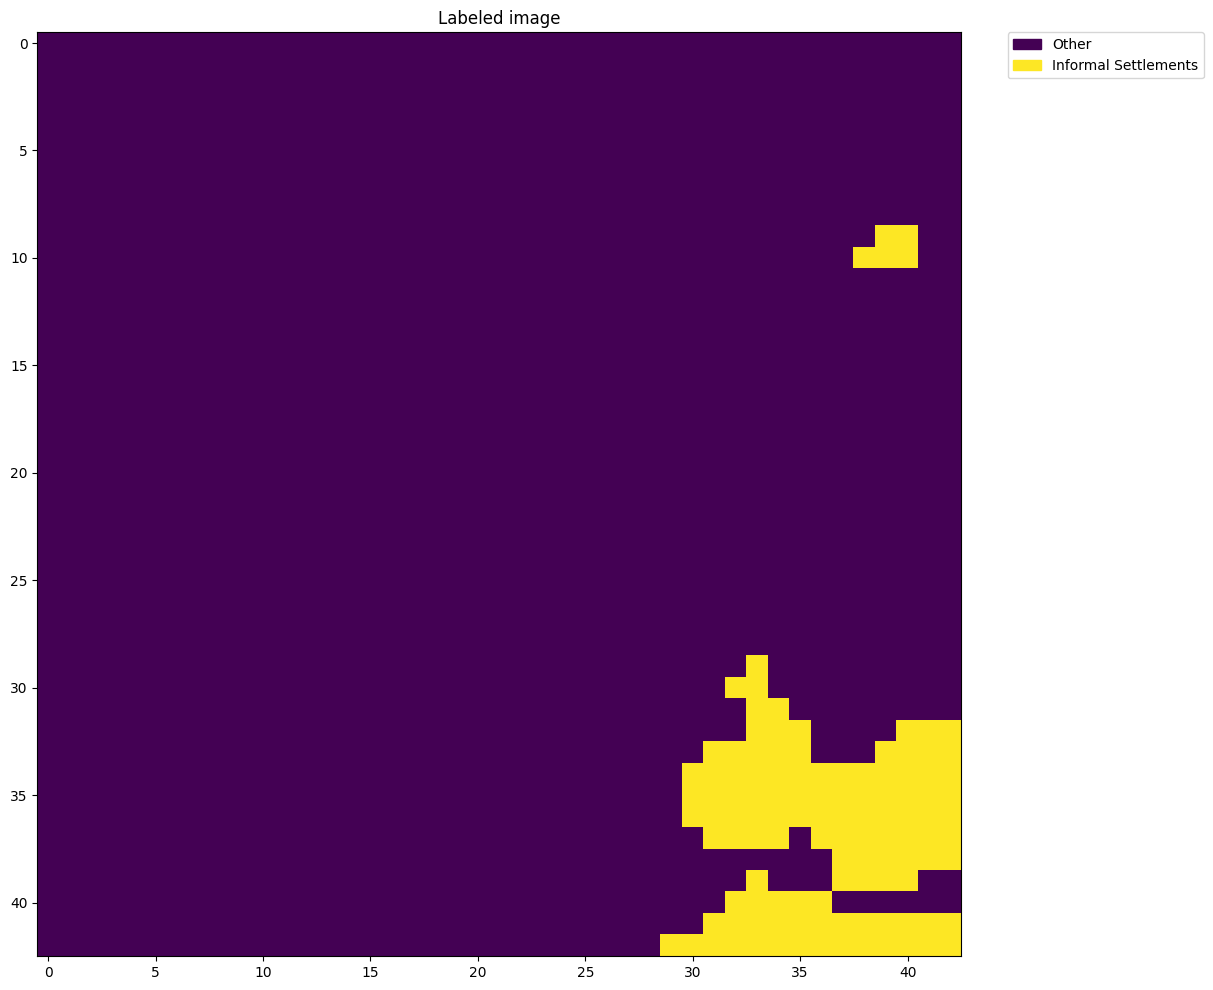

In [21]:
image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)

# visualize_data(image_tiles["area1"], "Sample training image tile 1")
visualize_labels(label_tiles["area1"])

In [85]:
PATCHSIZE = 43
NBANDS = image_tiles["area1"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)

# sample each training tile systematically in a gridwise manner
train_areas = ["area1", "area2", "area3", "area4", "area5", "area6", "area7", "area8"]
for area in train_areas:
    X_toadd = gridwise_sample(image_tiles[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))
print(Xtrain.shape)

There are 8 number of training patches
(8, 43, 43, 53)


In [84]:

# test tile
Xtest = image_tiles["area7"]
Ytest = label_tiles["area7"]




In [86]:
# let's compare a pixel-based classifier as a baseline
from sklearn.ensemble import RandomForestClassifier


# sample training points for random forest classifier
NSAMPLES_PER_PATCH = 43
npatches = Xtrain.shape[0]
nbands = Xtrain.shape[3]
nsamples = NSAMPLES_PER_PATCH*npatches
row_idx = np.random.randint(0, Xtrain.shape[1]-1, NSAMPLES_PER_PATCH)
col_idx = np.random.randint(0, Xtrain.shape[2]-1, NSAMPLES_PER_PATCH)
Xtrain_RF = np.zeros((nsamples, nbands), dtype=np.float32)
Ytrain_RF = np.zeros((nsamples), dtype=int)
idx = 0
for i in range(npatches):
    for r, c in zip(row_idx, col_idx):
        Xtrain_RF[idx, :] = Xtrain[i, r, c, :]
        Ytrain_RF[idx] = np.argmax(Ytrain[i, r, c, :], axis=0)
        idx += 1
# train random forest classifier
# and predict test set
clf = RandomForestClassifier(n_estimators=2000, max_depth=20, random_state=0)
clf.fit(Xtrain_RF, Ytrain_RF)
Xtest_RF = Xtest.reshape(Xtest.shape[0]*Xtest.shape[1], Xtest.shape[2])
print(Xtest_RF.shape)
predictions_RF = clf.predict(Xtest_RF)
print(predictions_RF.shape)
predictions_RF = predictions_RF.reshape(Xtest.shape[0], Xtest.shape[1])

(1849, 53)
(1849,)


In [80]:
# from sklearn.metrics import classification_report
#
# print(classification_report(Xtest_RF, predictions_RF))

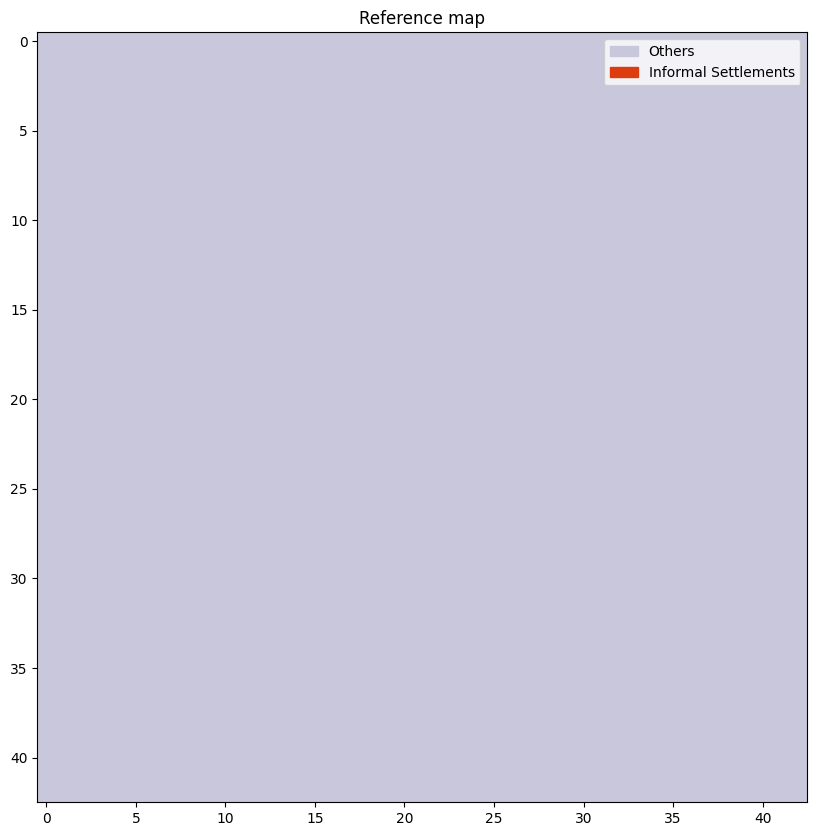

Accuracy metrics of Random Forest results
Overall Accuracy: 1.000000
PA of others: 1.000000
PA of informal settlements: nan


/tmp/ipykernel_15903/1591616404.py:116: RuntimeWarning: invalid value encountered in long_scalars
  PA_slums_RF = ((predictions_RF[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)


In [87]:
import string
from matplotlib import colors

# set color codes of the classes
_others = [221, 61, 14]
_slums = [200, 199, 219]
ccolors = (_slums, _others)
NROWS, NCOLS, NBANDS = Xtest.shape


def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


# plot reference map
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Reference map")
rectangles = [mpatches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Others", "Informal Settlements"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

# evaluate Random Forest
mapidx = cartesian([range(predictions_RF.shape[0]), range(predictions_RF.shape[1])])
CM = get_confusion_matrix(predictions_RF, labels)
OA = np.sum(np.diag(CM))/predictions_RF.size
PA_others_RF = ((predictions_RF[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_slums_RF = ((predictions_RF[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
mapfname = "map_random_forests.tif"
print("Accuracy metrics of Random Forest results")
print("Overall Accuracy: %f" % OA)
print("PA of others: %f" % PA_others_RF)
print("PA of informal settlements: %f" % PA_slums_RF)